In [1]:
import pandas as pd
import numpy as np
import csv
import sqlite3
import matplotlib.pyplot as plt

In [2]:
cd "C:/Users/drewh/Documents/Flatiron Documents/Phase 1/movie_studio_analysis/zippedData"

C:\Users\drewh\Documents\Flatiron Documents\Phase 1\movie_studio_analysis\zippedData


CSV and STV:

    bom.movie_gross.csv.gz
    3386 rows, 5 columns
    rows - individual films
    Columns - title, studio, domestic gross, foreign gross, year
    
    tmdb.movies.csv.gz
    26517 rows, 10 columns
    Rows - individual films
    Columns - Unnamed: 0 (index duplicate), genre_ids, id, original_language, original_title, popularity, release_date, title, vote_average, vote_count
    
    tn.movie_budgets.csv.gz
    5782 rows, 6 columns
    Rows - individual films
    Columns - id, release_date, movie, production_budget, domestic_gross, worldwide_gross
    
    rt.movie_info.tsv.gz
    To open: pd.read_csv("./rt.movie_info.tsv.gz", sep="\t")
    1560 rows, 12 columns
    Rows - individual films
    Columns - id, synopsis, rating, genre, director, writer, theater_date, dvd_date, currency, box_office, runtime, studio
    
    ./rt.reviews.tsv.gz
    to open: pd.read_csv("./rt.reviews.tsv.gz", sep="\t", encoding = 'unicode_escape')
    54432 rows, 8 columns
    Rows - 
    Columns - id, review, rating, fresh, critic, top_critic, publisher, data

SQL Tables

    movie_basics
    146144 rows, 6 columns
    Columns: movie_id, primary_title, original_title, start_year,
             runtime_minutes, genres
    
    directors
    291174 rows, 2 columns
    Columns: movie_id, person_id
    
    known_for
    1638260 rows, 2 columns
    Columns: person_id, movie_id
    
    movie_akas
    331703 rows, 8 columns
    Columns: movie_id, ordering, title, region, language, types, attributes, is_original_title
    
    movie_ratings
    73856 rows, 3 columns
    Columns: movie_id, averagerating, numvotes
    
    persons
    606648 rows × 5 columns
    Columns: person_id, primary_name, birth_year, death_year, primary_profession
             
    principals
    1028186 rows, 6 columns
    Columns: movie_id, ordering, person_id, category, job, characters
    
    writers
    255873 rows, 2 columns
    Columns: movie_id, person_id

Synthesis!
We have two tables with income information: BOM and TN. There's also some in the RT TSV, but very few of those films have box office values associated with them.

Variables we have:
-Runtime
-Studio
-Rating
-Genre
-Original language
-Production budget
-Ratings(i.e. reviews)
-People
    -Writers, directors, actors
    
For audience: the money made is the measure of success. What impacts that?
    -Ratings is an intermediary. Do positive ratings help? What improves ratings?
    -Are there particularly profitable individuals? Writers, directors, actors, etc.?

In [3]:
ls

 Volume in drive C is Windows-SSD
 Volume Serial Number is 5CA0-02C2

 Directory of C:\Users\drewh\Documents\Flatiron Documents\Phase 1\movie_studio_analysis\zippedData

10/05/2022  10:32 AM    <DIR>          .
10/04/2022  10:11 AM    <DIR>          ..
09/30/2022  05:14 PM            53,544 bom.movie_gross.csv.gz
12/20/2021  04:31 PM       169,443,328 Ignore - im.db
10/05/2022  10:32 AM                 0 im.db
09/30/2022  05:14 PM           498,202 rt.movie_info.tsv.gz
09/30/2022  05:14 PM         3,402,194 rt.reviews.tsv.gz
09/30/2022  05:14 PM           827,840 tmdb.movies.csv.gz
09/30/2022  05:14 PM           153,218 tn.movie_budgets.csv.gz
               7 File(s)    174,378,326 bytes
               2 Dir(s)  34,511,843,328 bytes free


In [4]:
movie_budgets = pd.read_csv("tn.movie_budgets.csv.gz")

In [5]:
movie_budgets["production_budget"]
def clean_money(df, money_column):
    df[money_column] = df[money_column].str.replace(',','')
    df[money_column] = df[money_column].str.replace('$','')
    df[money_column] = pd.to_numeric(df[money_column])
    return df

#cleaning
movie_budgets = clean_money(movie_budgets,'production_budget')
movie_budgets = clean_money(movie_budgets,'domestic_gross')
movie_budgets = clean_money(movie_budgets,'worldwide_gross')

In [6]:
movie_budgets["profit"] = movie_budgets["worldwide_gross"] - movie_budgets["production_budget"]
movie_budgets

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-200237650
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,999721747
...,...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,7000,0,0,-7000
5778,79,"Apr 2, 1999",Following,6000,48482,240495,234495
5779,80,"Jul 13, 2005",Return to the Land of Wonders,5000,1338,1338,-3662
5780,81,"Sep 29, 2015",A Plague So Pleasant,1400,0,0,-1400


In [7]:
con = sqlite3.connect("./Ignore - im.db")
cursor = con.cursor()

In [8]:
pd.read_sql("""
SELECT *
FROM sqlite_master
""", con)

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [109]:
persons = pd.read_sql("""
SELECT *
FROM persons
""", con)
persons

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator"
...,...,...,...,...,...
606643,nm9990381,Susan Grobes,NaN,NaN,actress
606644,nm9990690,Joo Yeon So,NaN,NaN,actress
606645,nm9991320,Madeline Smith,NaN,NaN,actress
606646,nm9991786,Michelle Modigliani,NaN,NaN,producer


In [10]:
writers = pd.read_sql("""
SELECT *
FROM writers
""", con)
writers

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0438973,nm0175726
2,tt0438973,nm1802864
3,tt0462036,nm1940585
4,tt0835418,nm0310087
...,...,...
255868,tt8999892,nm10122246
255869,tt8999974,nm10122357
255870,tt9001390,nm6711477
255871,tt9004986,nm4993825


In [11]:
full_writers = writers.merge(persons, left_on="person_id", right_on="person_id", how="left")
full_writers.drop(labels=["person_id", "birth_year", "primary_profession"], axis=1, inplace=True)
full_writers = full_writers.rename(columns={"primary_name": "writer_name"})

In [12]:
films = pd.read_sql("""
SELECT *
FROM movie_basics
""", con)

In [13]:
film_writers = full_writers.merge(films, left_on="movie_id", right_on="movie_id",
              how="left")
film_writers.drop(labels=["movie_id","genres", "runtime_minutes", "start_year", "original_title"], axis=1, inplace=True)

In [14]:
writer_profit = movie_budgets.merge(film_writers, left_on="movie", right_on="primary_title", how="left")
writer_profit.dropna(subset=["writer_name"], inplace=True)

In [15]:
clean_writers = writer_profit.drop_duplicates()

In [16]:
avg_writer_profit = clean_writers.drop_duplicates(subset="movie").mean()["profit"]

In [17]:
writer_films_strong = clean_writers.drop(clean_writers[clean_writers.profit < avg_writer_profit].index)

In [18]:
potential_writers = writer_films_strong.drop(writer_films_strong[writer_films_strong["death_year"]>1].index)

In [19]:
writer_pros = dict(potential_writers["writer_name"].value_counts())

In [20]:
writer_films_weak = clean_writers.drop(clean_writers[clean_writers.profit > avg_writer_profit].index)

In [21]:
questionable_writers = writer_films_weak.drop(writer_films_weak[writer_films_weak["death_year"]>1].index)

In [22]:
writer_cons = dict(questionable_writers["writer_name"].value_counts())

In [23]:
writer_points = {}
for writer in writer_pros:
    if writer in writer_cons:
        points = writer_pros[writer] - writer_cons[writer]
    else:
        points = writer_pros[writer]
    writer_points[writer] = points

In [24]:
top_writers = dict(sorted(writer_points.items(), key=lambda x:x[1], reverse=True))

In [25]:
writers_x = list(top_writers.keys())[:11]
writers_y = list(top_writers.values())[:11]

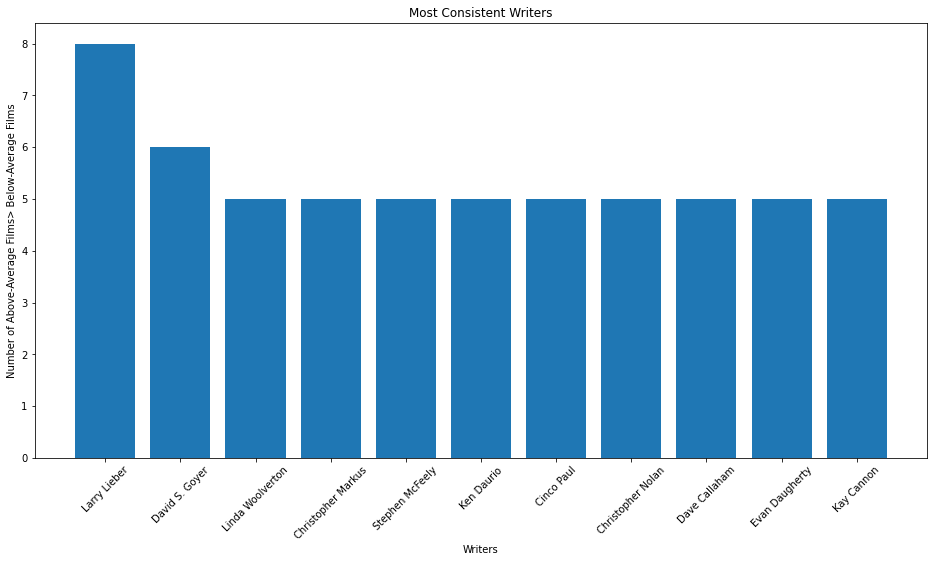

In [26]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.bar(x=writers_x, height=writers_y)

ax.set_xlabel('Writers')
ax.set_ylabel('Number of Above-Average Films> Below-Average Films')
ax.set_title('Most Consistent Writers')
plt.xticks(rotation=45);

# Directors

In [27]:
directors = pd.read_sql("""
SELECT *
FROM directors
""", con)

In [28]:
full_directors = directors.merge(persons, left_on="person_id", right_on="person_id", how="left")
full_directors.drop(labels=["person_id", "birth_year", "primary_profession"], axis=1, inplace=True)
full_directors = full_directors.rename(columns={"primary_name": "director_name"})

In [29]:
film_directors = full_directors.merge(films, left_on="movie_id", right_on="movie_id",
              how="left")
film_directors.drop(labels=["movie_id","genres", "runtime_minutes", "start_year", "original_title"], axis=1, inplace=True)

In [30]:
dir_profit = movie_budgets.merge(film_directors, left_on="movie", right_on="primary_title", how="left")
dir_profit.dropna(subset=["director_name"], inplace=True)

In [31]:
clean_dir = dir_profit.drop_duplicates()

In [32]:
avg_dir_profit = clean_dir.drop_duplicates(subset="movie").mean()["profit"]

In [33]:
dir_films_strong = clean_dir.drop(clean_dir[clean_dir.profit < avg_dir_profit].index)
potential_dir = dir_films_strong.drop(dir_films_strong[dir_films_strong["death_year"]>1].index)
dir_pros = dict(potential_dir["director_name"].value_counts())

In [36]:
dir_films_weak = clean_dir.drop(clean_dir[clean_dir.profit > avg_dir_profit].index)
questionable_dir = dir_films_weak.drop(dir_films_weak[dir_films_weak["death_year"]>1].index)
dir_cons = dict(questionable_dir["director_name"].value_counts())

In [39]:
dir_points = {}
for _dir in dir_pros:
    if _dir in dir_cons:
        points = dir_pros[_dir] - dir_cons[_dir]
    else:
        points = dir_pros[_dir]
    dir_points[_dir] = points

In [40]:
top_dir = dict(sorted(dir_points.items(), key=lambda x:x[1], reverse=True))

In [41]:
dir_x = list(top_dir.keys())[:9]
dir_y = list(top_dir.values())[:9]

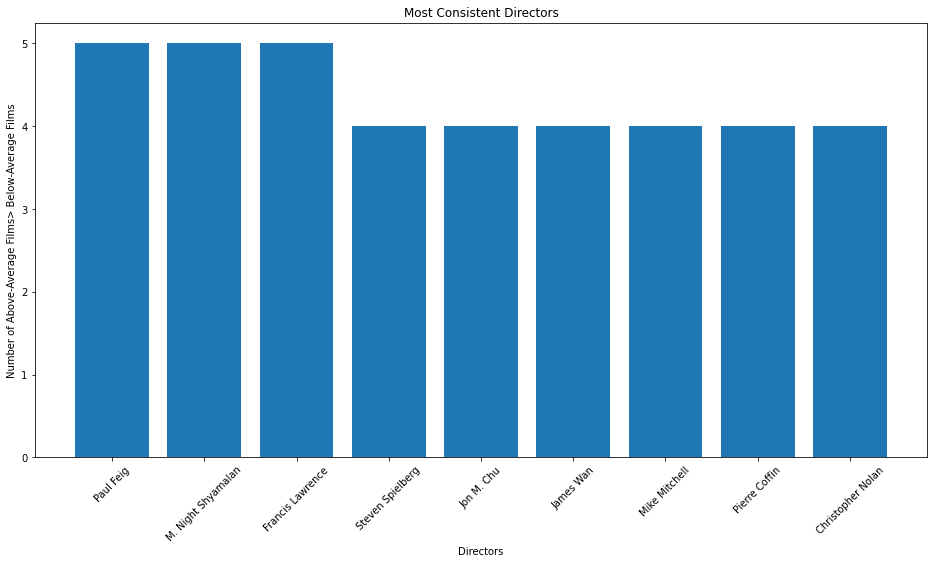

In [42]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.bar(x=dir_x, height=dir_y)

ax.set_xlabel('Directors')
ax.set_ylabel('Number of Above-Average Films> Below-Average Films')
ax.set_title('Most Consistent Directors')
plt.xticks(rotation=45);

# Actors

In [116]:
principals =  pd.read_sql("""
SELECT *
FROM principals
""", con)

In [117]:
actors = principals.drop(principals[(principals.category != "actress")&(principals.category != "actor")].index)
actors.drop(labels=["job", "characters", "ordering", "category"], axis=1, inplace=True)

In [120]:
full_actors = actors.merge(persons, left_on="person_id", right_on="person_id", how="left")
full_actors.drop(labels=["birth_year", "primary_profession"], axis=1, inplace=True)
full_actors = full_actors.rename(columns={"primary_name": "actor_name"})

In [121]:
film_actors = full_actors.merge(films, left_on="movie_id", right_on="movie_id", how="left")
film_actors.drop(labels=["movie_id","genres", "runtime_minutes", "start_year", "original_title"], axis=1, inplace=True)

In [123]:
actor_profit = movie_budgets.merge(film_actors, left_on="movie", right_on="primary_title", how="left")
actor_profit.dropna(subset=["actor_name"], inplace=True)

In [124]:
clean_actors = actor_profit.drop_duplicates()

In [127]:
avg_actor_profit = clean_actors.drop_duplicates(subset="movie").mean()["profit"]

In [128]:
actor_films_strong = clean_actors.drop(clean_actors[clean_actors.profit < avg_actor_profit].index)
potential_actors = actor_films_strong.drop(actor_films_strong[actor_films_strong["death_year"]>1].index)
actor_pros = dict(potential_actors["actor_name"].value_counts())

In [129]:
actor_films_weak = clean_actors.drop(clean_actors[clean_actors.profit > avg_actor_profit].index)
questionable_actors = actor_films_weak.drop(actor_films_weak[actor_films_weak["death_year"]>1].index)
actor_cons = dict(questionable_actors["actor_name"].value_counts())

In [130]:
actor_points = {}
for actor in actor_pros:
    if actor in actor_cons:
        points = actor_pros[actor] - actor_cons[actor]
    else:
        points = actor_pros[actor]
    actor_points[actor] = points

In [137]:
top_actors = dict(sorted(actor_points.items(), key=lambda x:x[1], reverse=True))

In [146]:
actor_x = list(top_actors.keys())[:12]
actor_y = list(top_actors.values())[:12]

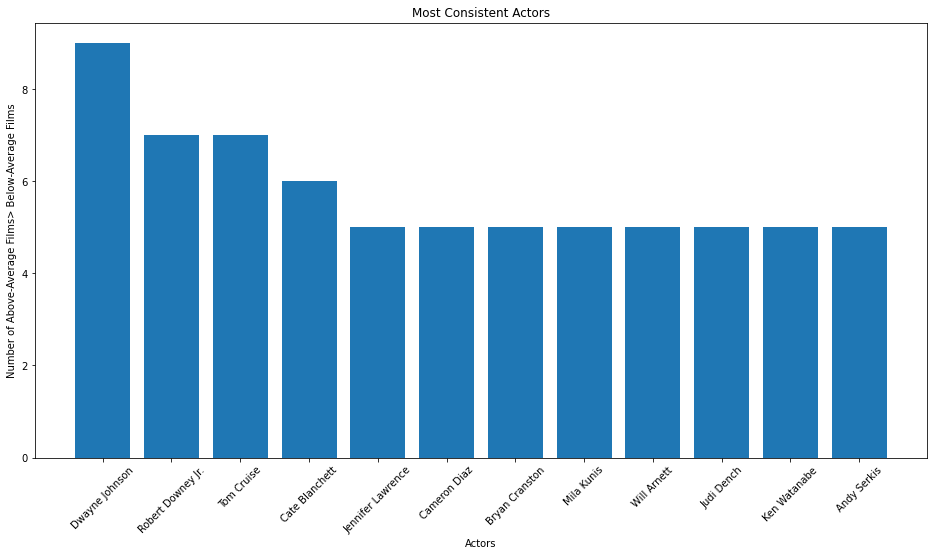

In [147]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.bar(x=actor_x, height=actor_y)

ax.set_xlabel('Actors')
ax.set_ylabel('Number of Above-Average Films> Below-Average Films')
ax.set_title('Most Consistent Actors')
plt.xticks(rotation=45);